### This is a notebook to format your data for segmentation, run the images through the cloud instance of Mesmer, and then extract marker counts and morphological information from all the cells in your images

In [1]:
# import required packages
import os
import warnings
import skimage.io as io
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from ark.utils import data_utils, example_dataset, deepcell_service_utils, io_utils, plot_utils, segmentation_utils
from ark.segmentation import marker_quantification

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

If you're interested in directly interfacing with Google Drive, consult the documentation [here](https://ark-analysis.readthedocs.io/en/latest/_rtd/google_docs_usage.html).

In [2]:
# set up file paths
base_dir = "../data/example_dataset"
tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table")
deepcell_input_dir = os.path.join(base_dir, "segmentation/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/deepcell_output")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/deepcell_visualization")

In [3]:
# create directories if do not exist
for directory in [cell_table_dir, deepcell_input_dir, deepcell_output_dir, deepcell_visualization_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

### Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change the `base_dir` to point to your own sub-directory within the data folder, rather than `'example_dataset'`. 

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels.

In [4]:
example_dataset.get_example_dataset(dataset="segment_image_data", save_dir = base_dir)

Reusing dataset ark_example (/Users/srivarra/.cache/huggingface/datasets/angelolab___ark_example/nb1/0.0.2/20d8714b07f26b4829eb9d45b77e6af03ed09b1da257713e47c7b607a6c9bb16)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# validate paths
io_utils.validate_paths([base_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         cell_table_dir,
                         deepcell_visualization_dir
                         ])

### compute and filter fov paths

In [6]:
# either get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov0", "fov1"]

### load images into notebook, process, and save as Mesmer compatable input

In [7]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
nucs = ['H3K9ac', 'H3K27me3']

# membrane channel name(s) (or mems = None)
mems = ['CD14', 'CD45', 'ECAD']

In [8]:
# generate and save deepcell input tifs
# set img_sub_folder param to None if the image files in tiff_dir are not in a separate sub folder 
data_utils.generate_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    fovs,
    is_mibitiff=False,
    img_sub_folder=None
)

## Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [9]:
# Mesmer was trained on data acquired at 20X resolution. If your image data was acquired at a different resolution, you will get the best performance by rescaling. The rescale factor will increase or decrease the image resolution by the value you provide. For example, if you data was acquired at 10X, use a `rescale_factor` of 2. If your data was acquired at 60X resolution, use a `rescale_factor` of 0.33.
rescale_factor = 1.0

In [10]:
deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs, scale=rescale_factor)

Processing tiffs in 3 batches...
Zipping preprocessed tif files.


/Users/srivarra/Angelo Lab/ark-analysis/ark/utils/deepcell_service_utils.py:104: UserWarning: ../data/example_dataset/segmentation/deepcell_input/fovs_batch_1.zip will be overwritten
  warnings.warn(f'{zip_path} will be overwritten')


Uploading files to DeepCell server.
Segmentation progress:


  0%|          | 0/100 [00:00<?]

Extracting tif files from DeepCell response.
Zipping preprocessed tif files.
Uploading files to DeepCell server.
Segmentation progress:


  0%|          | 0/100 [00:00<?]

Extracting tif files from DeepCell response.
Zipping preprocessed tif files.
Uploading files to DeepCell server.
Segmentation progress:


  0%|          | 0/100 [00:00<?]

Extracting tif files from DeepCell response.


### We can then save the segmented mask overlaid on the imaging data

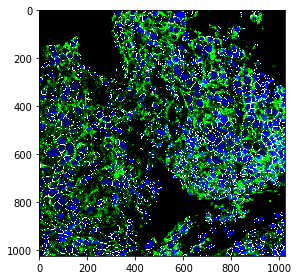

In [11]:
# display the channel overlay for a fov, useful for quick verification
warnings.simplefilter("ignore")

fov_to_display = io_utils.remove_file_extensions([fovs[0]])[0]

fov_overlay = plot_utils.create_overlay(
    fov=fov_to_display,
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)

io.imshow(fov_overlay)

In [12]:
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fovs),
    channels=['nuclear_channel', 'membrane_channel']
)

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [13]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = False

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [14]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              is_mibitiff=False,
                                              fovs=fovs,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts)

extracting data from fov0
extracting data from fov1
extracting data from fov10
extracting data from fov2
extracting data from fov3
extracting data from fov4
extracting data from fov5
extracting data from fov6
extracting data from fov7
extracting data from fov8
extracting data from fov9


In [15]:
# save extracted data as csv for downstream analysis
cell_table_size_normalized.to_csv(os.path.join(cell_table_dir, 'cell_table_size_normalized.csv'),
                                 index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                     index=False)